### Importing libraries and data

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier,plot_tree

from sklearn.metrics import accuracy_score

In [2]:
df1=pd.read_csv("/kaggle/input/sepsis-survival-minimal-clinical-records/s41598-020-73558-3_sepsis_survival_dataset/s41598-020-73558-3_sepsis_survival_primary_cohort.csv")
df1.head(10)

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1
5,83,0,1,1
6,74,0,1,1
7,74,1,1,1
8,69,0,1,1
9,53,1,1,1


* episode_number: Number of prior Sepsis episodes
* hospital_outcome: 1 alive, 0 dead
* sex: 0 male, 1 female

### Exploring the Data

In [3]:
df1.shape

(110204, 4)

In [4]:
df1.describe()

,age_years,sex_0male_1female,episode_number,hospital_outcome_1alive_0dead
count,110204.000000,110204.000000,110204.000000,110204.000000
mean,62.735255,0.473948,1.349379,0.926455
std,24.126806,0.499323,0.751799,0.261031
min,0.000000,0.000000,1.000000,0.000000
25%,51.000000,0.000000,1.000000,1.000000
50%,68.000000,0.000000,1.000000,1.000000
75%,81.000000,1.000000,1.000000,1.000000
max,100.000000,1.000000,5.000000,1.000000


In [5]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110204 entries, 0 to 110203
Data columns (total 4 columns):
 #   Column                         Non-Null Count   Dtype
---  ------                         --------------   -----
 0   age_years                      110204 non-null  int64
 1   sex_0male_1female              110204 non-null  int64
 2   episode_number                 110204 non-null  int64
 3   hospital_outcome_1alive_0dead  110204 non-null  int64
dtypes: int64(4)
memory usage: 3.4 MB


From the info method, we can see that there are no missing values. We can reconfirm that by writing the code below:

In [6]:
#check missing values
df1.isnull().sum()

age_years                        0
sex_0male_1female                0
episode_number                   0
hospital_outcome_1alive_0dead    0
dtype: int64

In [7]:
#renaming the name of columns
new_columns={
    'age_years':'Age',"sex_0male_1female":'Sex','episode_number':'PrevSepsis Count'
    ,'hospital_outcome_1alive_0dead':'Hospital Outcome'
}
df1=df1.rename(columns=new_columns)


In [8]:
df1.head(10)

,Age,Sex,PrevSepsis Count,Hospital Outcome
0,21,1,1,1
1,20,1,1,1
2,21,1,1,1
3,77,0,1,1
4,72,0,1,1
5,83,0,1,1
6,74,0,1,1
7,74,1,1,1
8,69,0,1,1
9,53,1,1,1


In [9]:
#set color theme
color1 = "#FA8072" #salmon
color2 = "#e5c9b2" #biege
color3 = "#F08080" #coral
color4 = "#8aa192" #sage

color_set1 = [color1, color2]
color_set2 = [color3, color4]

<Figure size 1000x600 with 0 Axes>

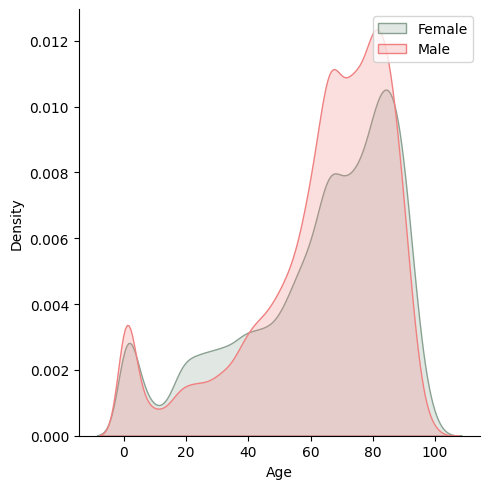

In [10]:
plt.figure(figsize=(10, 6))
fig4=sns.displot(data=df1, x="Age", hue="Sex", kind="kde", fill=True, palette=color_set2, legend=False)
plt.legend(labels = ["Female", "Male"])

plt.show()

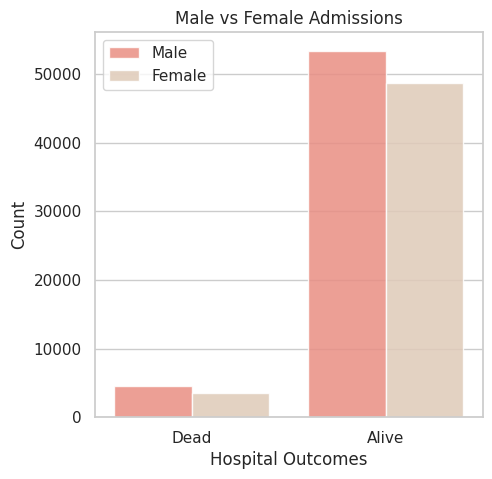

In [11]:
#countplot of Hospital Outcomes
plt.figure(figsize=(5,5))
sns.set_theme(style="whitegrid")

fig1=sns.countplot(data=df1, x='Hospital Outcome', hue="Sex", palette=color_set1, alpha=.85)
fig1.set_title("Male vs Female Admissions")
fig1.set_xlabel('Hospital Outcomes', fontsize=12)
fig1.set_ylabel('Count', fontsize=12)
plt.legend(labels = ["Male", "Female"])

outcome= ["Dead","Alive"]
plt.xticks(ticks=[0,1], labels=outcome)

plt.show()

From the count plot, we can see that there are more patients who survived as compared to patients who have died due to sepsis. This is an indication of data imbalance. We will need to take this into account when training the model. 

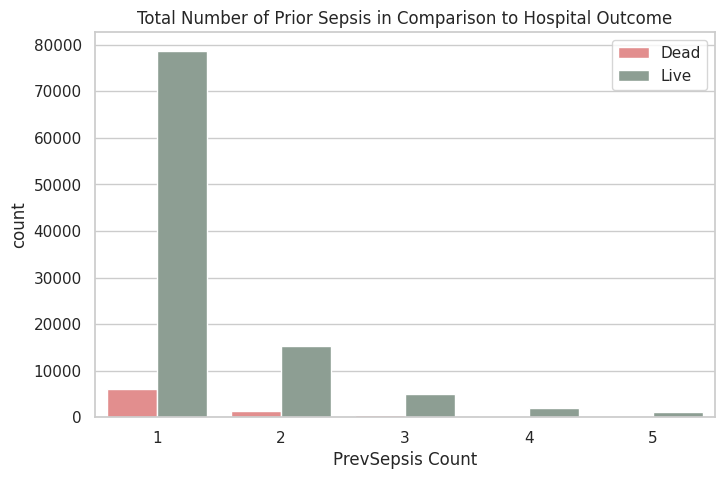

In [12]:
plt.figure(figsize=(8, 5))
fig2=sns.countplot(df1, x="PrevSepsis Count", hue="Hospital Outcome", palette=color_set2)
fig2.set_title("Total Number of Prior Sepsis in Comparison to Hospital Outcome")
plt.legend(labels = ["Dead", "Live"])
plt.show()

It seems like the number of previous sepsis count does not increase the death risk in patients, but rather, more deaths occured on the first sepsis infection. 

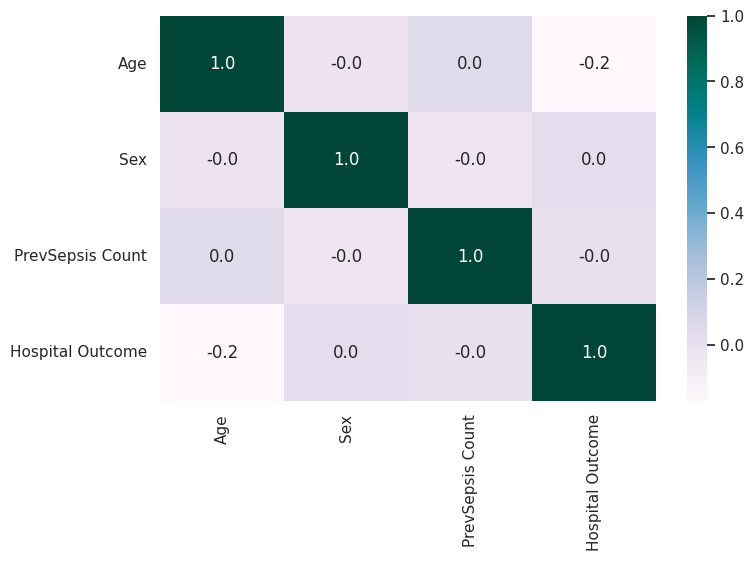

In [13]:
#heatmap of correlation between all columns
cor=df1.corr()
plt.figure(figsize=(8,5))
fig3=sns.heatmap(cor, annot=True, fmt=".1f", cmap="PuBuGn")
plt.show()

Doesn't look like there is much correalations going on between the variables. Not a good data to train for any use. In this case, we will only do a exploratory data analysis on the data.

In [14]:
# plotting data on chart 
df2 = df1.filter(items=['Sex', 'Hospital Outcome'])
df2

,Sex,Hospital Outcome
0,1,1
1,1,1
2,1,1
3,0,1
4,0,1
...,...,...
110199,0,1
110200,1,1
110201,1,1
110202,0,1


In [15]:
#Total admissions
len(df1)

110204

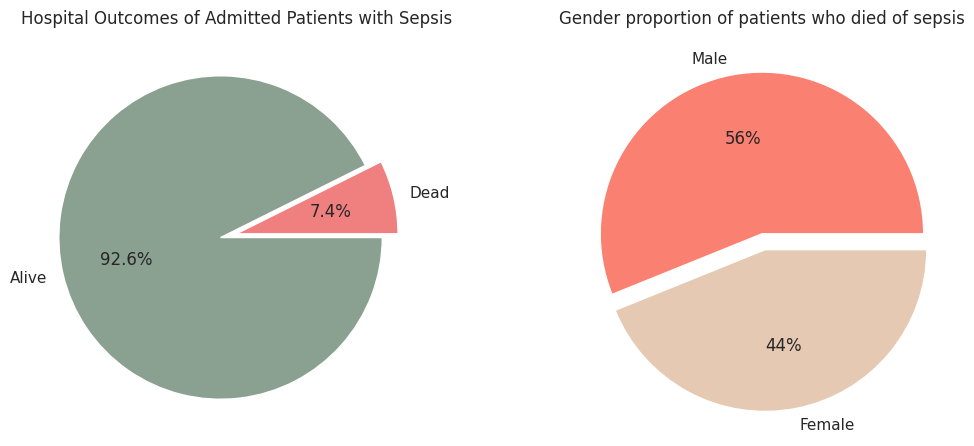

In [16]:
fig = plt.figure(figsize=(12, 12)) #plot background color, light grey
gs = fig.add_gridspec(1,2)
gs.update(wspace=0.3, hspace=0.4)

ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1]) 

#Percentage of live and dead
dead = df2[df2["Hospital Outcome"]==0].count()
alive = df2[df2["Hospital Outcome"]==1].count()

dead_percent = dead[0]/len(df1)*100
alive_percent = alive[0]/len(df1)*100

data = [dead_percent, alive_percent]
keys = ["Dead", "Alive"]

explode = (0, 0.1)
ax0.pie(data, labels=keys, autopct='%1.1f%%', colors=color_set2, explode=explode)
ax0.set_title('Hospital Outcomes of Admitted Patients with Sepsis')

#Percentage of dead by gender
df3 = df2[df2["Hospital Outcome"]==0]
dead_male = df3[df3["Sex"]==0]
dead_female = df3[df3["Sex"]==1]

male_percent = dead_male.count()/len(df3)*100
female_percent = dead_female.count()/len(df3)*100

data2 = [male_percent[0], female_percent[0]]
keys2 = ["Male", "Female"]

explode=(0, 0.1)
ax1.pie(data2, labels=keys2, autopct='%0.0f%%', colors=color_set1, explode=explode)
ax1.set_title('Gender proportion of patients who died of sepsis')

plt.show()


### Conclusion
From this analysis, we found that there were more Males than Females who have had sepsis, and there were 12% more Males than Females who died from Sepsis. The data is highly imbalanced, with only 7.4% of the total that have died of Sepsis. The age group who were most susceptible to sepsis is between age 60-80 years old, the numbers drop after 80, most likely due to the fact that there were lesser patients who were above 80 years old. This shows that patients who are older, are more likely to be susceptible to sepsis during admissions.

From the correlation matrix, it showed no strong correlations between the variables and therefore, training a model on these features not give accurate and almost random results. 

The data also showed that the number of deaths do not increase with the number of prior sepsis infections. Surprisingly, the most deaths occurred on the first episode. Therefore, early test and care are very important in detecting early stages of sepsis. 

### Thoughts
The early detection of sepsis is more likely to benefit from using data that consist of laboratory measurements rather than just age and number of prior infection episodes. I am intereted in finding a dataset with more lab measurements to train a model to help the detection of early sepsis. Please like and comment if you enjoyed this notebook, thank you. :)